In [57]:
from torch.autograd import Variable
import torch
import torch.autograd
import torch.nn.functional as F
import random
import numpy as np
from params_poly import p
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import pickle as pkl
from os.path import join as oj


In [58]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab




def set_style():
    plt.style.use('fivethirtyeight')
    label_size = 12
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['axes.labelsize'] = label_size
    mpl.rcParams['axes.titlesize'] = label_size
    mpl.rcParams['figure.titlesize'] = label_size
    mpl.rcParams['lines.markersize'] = 20
    mpl.rcParams['lines.linewidth'] = 3.
    mpl.rcParams['grid.linewidth'] = 1.
    mpl.rcParams['legend.fontsize'] = label_size
    pylab.rcParams['xtick.major.pad']=3
    pylab.rcParams['ytick.major.pad']=3

    pylab.rcParams['figure.facecolor']='white'
    pylab.rcParams['axes.facecolor']='white'
    # mpl.rcParams['figure.figsize'] = [12, 10]
    # mpl.rcParams.keys()
    # Say, "the default sans-serif font is COMIC SANS"
    # mpl.rcParams['font.serif'] = 'Times New Roman'
    # # Then, "ALWAYS use sans-serif fonts"
    # mpl.rcParams['font.family'] = "Serif"

import pandas as pd
from copy import deepcopy

In [59]:
set_style()

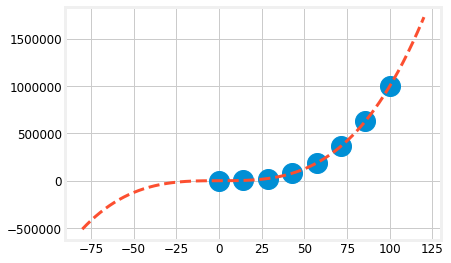

In [75]:
def square_el(x):
    return x * x

def cube_el(x):
    return x * x * x

def sin_el(x):
    return np.sin(x * 2 * np.pi / 100)

def make_data(func, N=4):
    X = np.linspace(0, 100, N)
    X_grid = np.linspace(-80, 120, 1000)
    Y = np.apply_along_axis(func, 0, X)
    Y_grid = np.apply_along_axis(func, 0, X_grid)            
    return X, Y, X_grid, Y_grid


def seed(p, repeat):
    s = p.seed + repeat * 13913
    # set random seed        
    np.random.seed(s) 
    torch.manual_seed(s)    
    random.seed(s)
    
## network
class LinearNet(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, output_size):
        # num_layers is number of weight matrices
        super(LinearNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # for one layer nets
        if num_layers == 1:
            self.fc = nn.ModuleList([nn.Linear(input_size, output_size)])
        else:
            self.fc = nn.ModuleList([nn.Linear(input_size, hidden_size)])
            self.fc.extend([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 2)])
            self.fc.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        y = x.view(-1, self.input_size)
        for i in range(len(self.fc) - 1):
            y = F.relu(self.fc[i](y))
        return self.fc[-1](y)

    
    
    
freeze = False    
hidden_size = 1024
repeats = 5
opt = 'adam'
lr = 1e-1
N = 8
func = cube_el # square
X, Y, X_grid, Y_grid = make_data(func, N)
plt.plot(X, Y, 'o')
plt.plot(X_grid, Y_grid, '--')

# run

In [76]:
X_t, Y_t = Variable(torch.Tensor(X)).cuda(), Variable(torch.Tensor(Y)).cuda()
models = []
num_hiddens = []
losses = []
seeds = []
opts = []
lrs = []

for i, nh in tqdm(enumerate([1, 2, 3, 4, 5, 7])):
    for repeat in range(repeats):
        seed(p, repeat)
        model = LinearNet(nh, input_size=1, hidden_size=hidden_size, output_size=1).cuda()

        if freeze:
            for name, param in model.named_parameters():
                if 'fc.0' in name:
                    param.requires_grad = True 
                else:
                    param.requires_grad = False

        if opt == 'adam':
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                              lr=lr) # wow Adam does way better
        else:
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr) # 1e6 worked 
        criterion =  torch.nn.MSELoss()
        for batch_idx in range(1000):
            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            loss = criterion(model(X_t), Y_t)

            # Backward pass
            loss.backward()

            # Apply gradients
            optimizer.step()
#         print('loss: {:.6f} after {} batches'.format(loss.data[0], batch_idx))

        
        # saving
        models.append(deepcopy(model))
        num_hiddens.append(nh)
        losses.append(loss.data[0])
        seeds.append(repeat)
        opts.append(opt)
        lrs.append(lr)

6it [01:22, 17.36s/it]


# make plot

In [77]:
# models_states = [model.cpu().state_dict() for model in models]
d = {'model': models, 'num_hidden': num_hiddens, 
     'loss': losses, 'seed': seeds, 'optimizer': opts, 'lr': lr}

# results.to_pickle('poly_runs_sin.pkl')
# pkl.dump(d, open('poly_runs_sin' + '.pkl', 'wb'))

results = pd.DataFrame.from_dict(d)       
# results = pd.read_pickle('poly_runs.pkl')

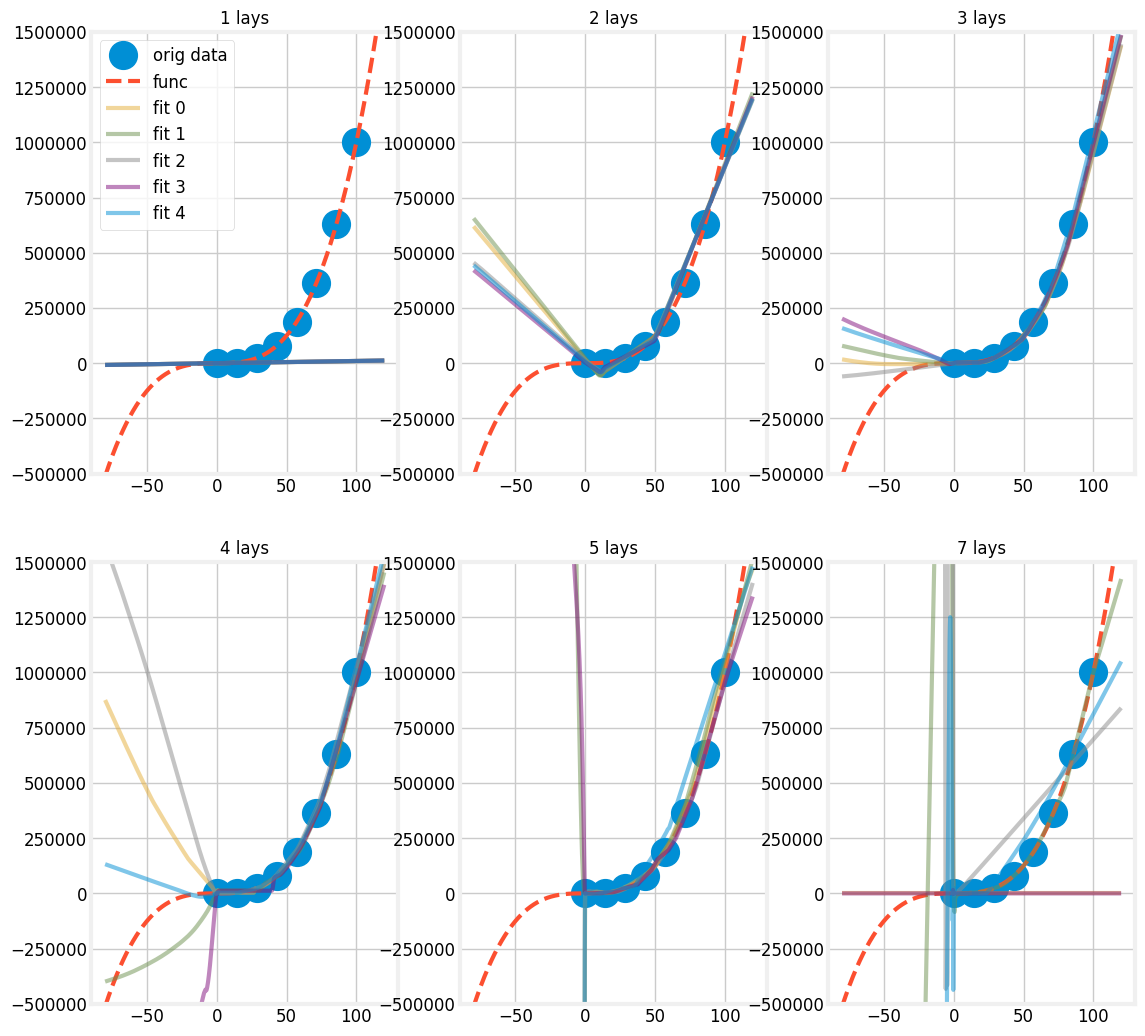

In [81]:
def plot_model(X, Y, X_grid, Y_grid, model, repeat):
    Xgrid = Variable(torch.Tensor(X_grid))
    yhat = model(Xgrid.cuda()).data.cpu().numpy()
    plt.plot(Xgrid.data.numpy(), yhat, label='fit ' + str(repeat), alpha=0.5)


plt.figure(figsize=(12, 12), dpi=100, facecolor='white')
R, C = 2, 3
X, Y, X_grid, Y_grid = make_data(func, N)

for i, nh in enumerate(sorted(set(results.num_hidden))): #([1, 2, 3, 4, 5, 7]):
    plt.subplot(R, C, i + 1)
    plt.plot(X, Y, 'o', label='orig data')
    plt.plot(X_grid, Y_grid, '--', label='func') 
    plt.ylim((-500000, 1500000))
    #     plt.ylim((-2000, 12000))

#     plt.ylim((-1.5, 1.5))

    plt.title(str(nh) + ' lays')
    for repeat in range(repeats):

        r = results[results.num_hidden == nh]
        r = r[r.seed == repeat]
        model = r.iloc[0].model.cuda()
            
        R, C = 2, 3
        plot_model(X, Y, X_grid, Y_grid, model, repeat)
        
        # saving
        models.append(deepcopy(model))
        num_hiddens.append(nh)
        losses.append(loss.data[0])
        seeds.append(repeat)
        opts.append(opt)
        lrs.append(lr)
        
    if i == 0:
        plt.legend()